<a href="https://www.kaggle.com/code/brmil07/multi-class-prediction?scriptVersionId=162278989" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Multi-Class Prediction of Obesity Risk 🍕**
---
This is my notebook for submission of "Multi-Class Prediction of Obesity Risk" of the Kaggle Playground Prediction Competition. This notebook aims to classify obesity levels using machine learning algorithms given the 17 attributes consist of numerical, continuous, and categorical data.

## **About the Dataset 🗨️**
---
The original dataset consist of the estimation of obesity levels in people from the countries of Mexico, Peru and Colombia, with ages between 14 and 61 and diverse eating habits and physical condition , data was collected using a web platform with a survey where anonymous users answered each question, then the information was processed obtaining 17 attributes and 2111 records. Then for this competition, The dataset (both train and test) was generated from a deep learning model trained on the Obesity or CVD risk dataset. Feature distributions are close to, but not exactly the same, as the original. 

More info:
* [Multi-Class Prediction of Obesity Risk](https://www.kaggle.com/competitions/playground-series-s4e2/data)
* [Obesity or CVD risk](https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil
from tqdm import tqdm

from sklearn.base import is_classifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [3]:
# Load the dataset
train_df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

In [4]:
# Locate the sample submission
sample_submission = pd.read_csv("/kaggle/input/playground-series-s4e2/sample_submission.csv")

# **Exploratory Data Analysis 🔍**
---

Here is a brief explanation of some of the columns:

* Gender: The gender of the individual (Male/Female).
* Age: The age of the individual.
* Height: The height of the individual.
* Weight: The weight of the individual.
* family_history_with_overweight: Indicates if there's a family history of overweight.
* FAVC: Frequent consumption of high caloric food.
* FCVC: Frequency of consumption of vegetables.
* NCP: Number of main meals.
* CAEC: Consumption of food between meals.
* SMOKE: Indicates if the individual smokes.
* CH2O: Consumption of water daily.
* SCC: Calories consumption monitoring.
* FAF: Physical activity frequency.
* TUE: Time using technology devices.
* CALC: Consumption of alcohol.
* MTRANS: Mode of transportation used.
* NObeyesdad: Obesity level.

## **Data Overview**
---

In [5]:
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
train_df.set_index('id', inplace=True)

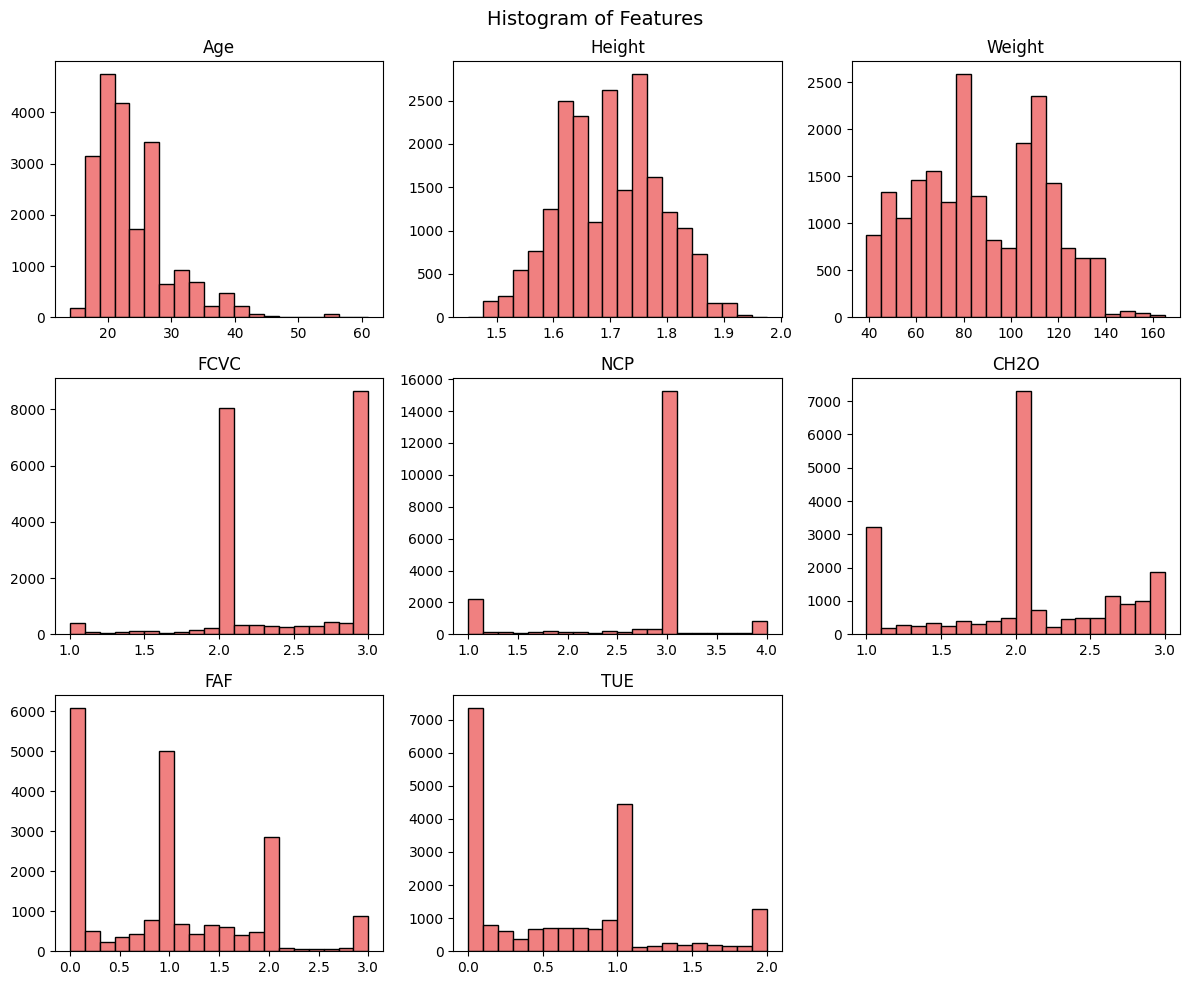

In [7]:
train_df.hist(bins=20, figsize=(12, 10), color='lightcoral', edgecolor='black', grid=False)
plt.suptitle('Histogram of Features', fontsize=14)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


In [9]:
train_df['Gender'].value_counts(ascending=True)

Gender
Male      10336
Female    10422
Name: count, dtype: int64

In [10]:
train_df['family_history_with_overweight'].value_counts(ascending=True)

family_history_with_overweight
no      3744
yes    17014
Name: count, dtype: int64

In [11]:
train_df['NObeyesdad'].value_counts(ascending=True)

NObeyesdad
Overweight_Level_I     2427
Overweight_Level_II    2522
Insufficient_Weight    2523
Obesity_Type_I         2910
Normal_Weight          3082
Obesity_Type_II        3248
Obesity_Type_III       4046
Name: count, dtype: int64

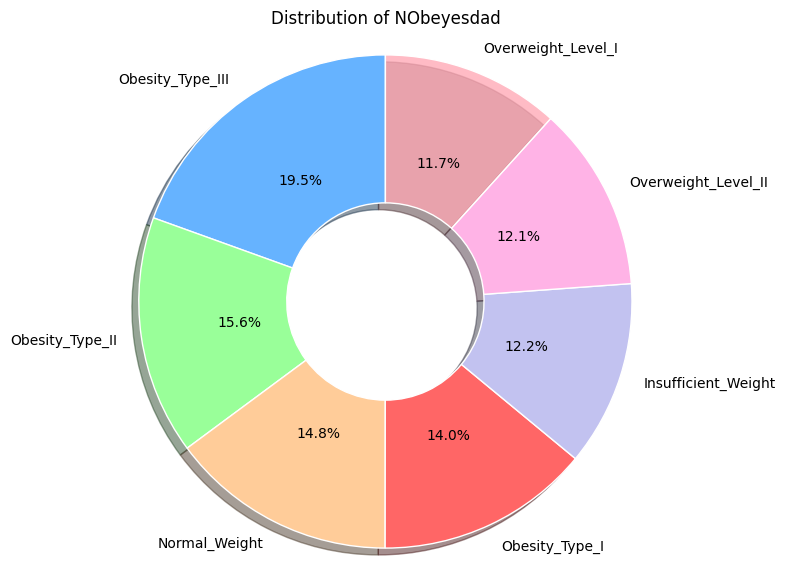

In [12]:
# Calculate the value counts
value_counts = train_df["NObeyesdad"].value_counts()

# Set custom colors for the pie chart
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#c2c2f0', '#ffb3e6', '#ffa6b3c1']

# Create a pie chart
plt.figure(figsize=(7, 7))
plt.pie(value_counts,
        explode=(0, 0, 0, 0, 0, 0, 0),
        labels=value_counts.index,
        autopct='%1.1f%%',
        colors=colors,
        shadow=True,
        startangle=90, 
        wedgeprops=dict(width=0.6, edgecolor='w'))  

plt.title('Distribution of NObeyesdad')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## **Data Cleaning 🧹**
---

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             20758

In [14]:
# Identify categorical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()

# Print the list of categorical columns
print("Categorical Columns:")
print(categorical_columns)

Categorical Columns:
['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [15]:
# Check for duplicates
train_df.duplicated().sum()

0

In [16]:
# Check for missing values
train_df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [17]:
# Return the number of unique values for each column
train_df.nunique()

Gender                               2
Age                               1703
Height                            1833
Weight                            1979
family_history_with_overweight       2
FAVC                                 2
FCVC                               934
NCP                                689
CAEC                                 4
SMOKE                                2
CH2O                              1506
SCC                                  2
FAF                               1360
TUE                               1297
CALC                                 3
MTRANS                               5
NObeyesdad                           7
dtype: int64

## **Feature Selection**
---

In [18]:
train_df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [19]:
t_df = train_df[train_df.columns]

In [20]:
t_df.drop('NObeyesdad', axis=1)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation


In [21]:
labelencoder = LabelEncoder()
for col in t_df.columns:
    if t_df[col].dtypes == 'object':
        t_df.loc[:, col] = labelencoder.fit_transform(t_df[col])

In [22]:
t_df[:10].style.background_gradient(cmap='crest')

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2,0,2.763573,0,0.000000,0.976473,1,3,6
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,2,0,1
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,2,0,1.910378,0,0.866045,1.673584,2,3,0
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,2,0,1.674061,0,1.467863,0.780199,1,3,4
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,2,0,1.979848,0,1.967973,0.931721,1,3,6
5,1,18.128249,1.748524,51.552595,1,1,2.919751,3.000000,2,0,2.137550,0,1.930033,1.000000,1,3,0
6,1,29.883021,1.754711,112.725005,1,1,1.991240,3.000000,2,0,2.000000,0,0.000000,0.696948,1,0,3
7,1,29.891473,1.750150,118.206565,1,1,1.397468,3.000000,2,0,2.000000,0,0.598655,0.000000,1,0,3
8,1,17.000000,1.700000,70.000000,0,1,2.000000,3.000000,2,0,3.000000,1,1.000000,1.000000,2,3,5


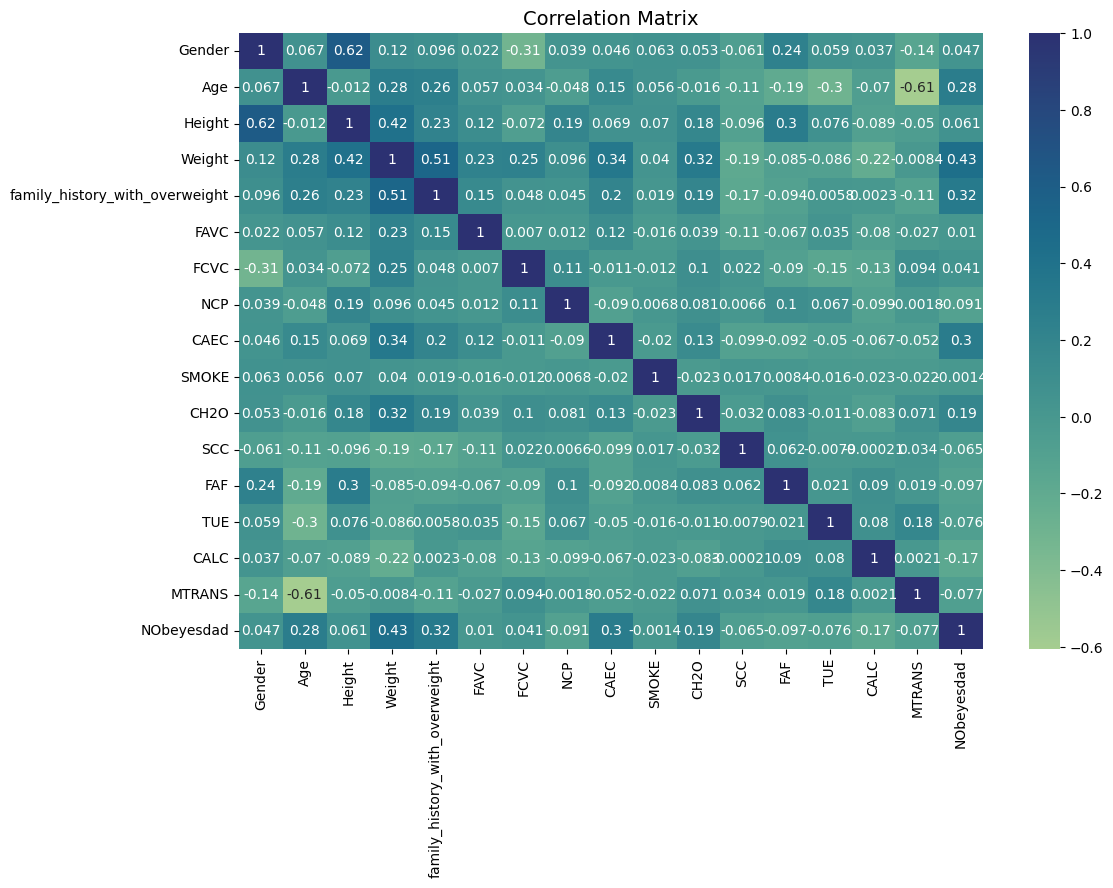

In [23]:
corr = t_df.corr()
# plot the heatmap
plt.figure(figsize=(12, 8))
plt.rcParams['figure.facecolor'] = 'lightgrey'
s=sns.heatmap(corr,annot=True, cmap='crest')
plt.title("Correlation Matrix", fontsize=14)
plt.show()

# **Data Preprocessing'🛠️**
---

In [24]:
# Column 'NObeyesdad' is the target variable
X = train_df.drop(['NObeyesdad'], axis=1)
y = train_df['NObeyesdad']

# Fit and transform the target variable
y = labelencoder.fit_transform(y)

In [25]:
# Identifying categorical features
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Creating transformers for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = StandardScaler()

# Pipeline for transforming categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

# **Build the Model 🤖**
---

In [27]:
lgbm_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "random_state": 42,
    "num_class": 7,
    'learning_rate': 0.030962211546832760,
    'n_estimators': 550,
    'lambda_l1': 0.009667446568254372,
    'lambda_l2': 0.04018641437301800,
    'max_depth': 20,
    'colsample_bytree': 0.40977129346872643,
    'subsample': 0.9535797422450176,
    'min_child_samples': 26,   
    'class_weight':'balanced'
}

classifiers = {
    'LightGBM': LGBMClassifier(**lgbm_params,
                               force_col_wise=True,  
                               verbose=-1),
    'CatBoost': CatBoostClassifier(eval_metric='Accuracy',
                                   random_seed=56,    
                                   iterations=2000,
                                   verbose=False),
    'XGBoost': XGBClassifier(learning_rate=0.01, 
                             n_estimators=5000, 
                             random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=2),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=700,
                                                    random_state=77,
                                                    criterion='entropy',    
                                                    max_depth=20,
                                                    class_weight='balanced'),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
}

performance_list = []

Training models: 100%|██████████| 9/9 [05:23<00:00, 35.95s/model]


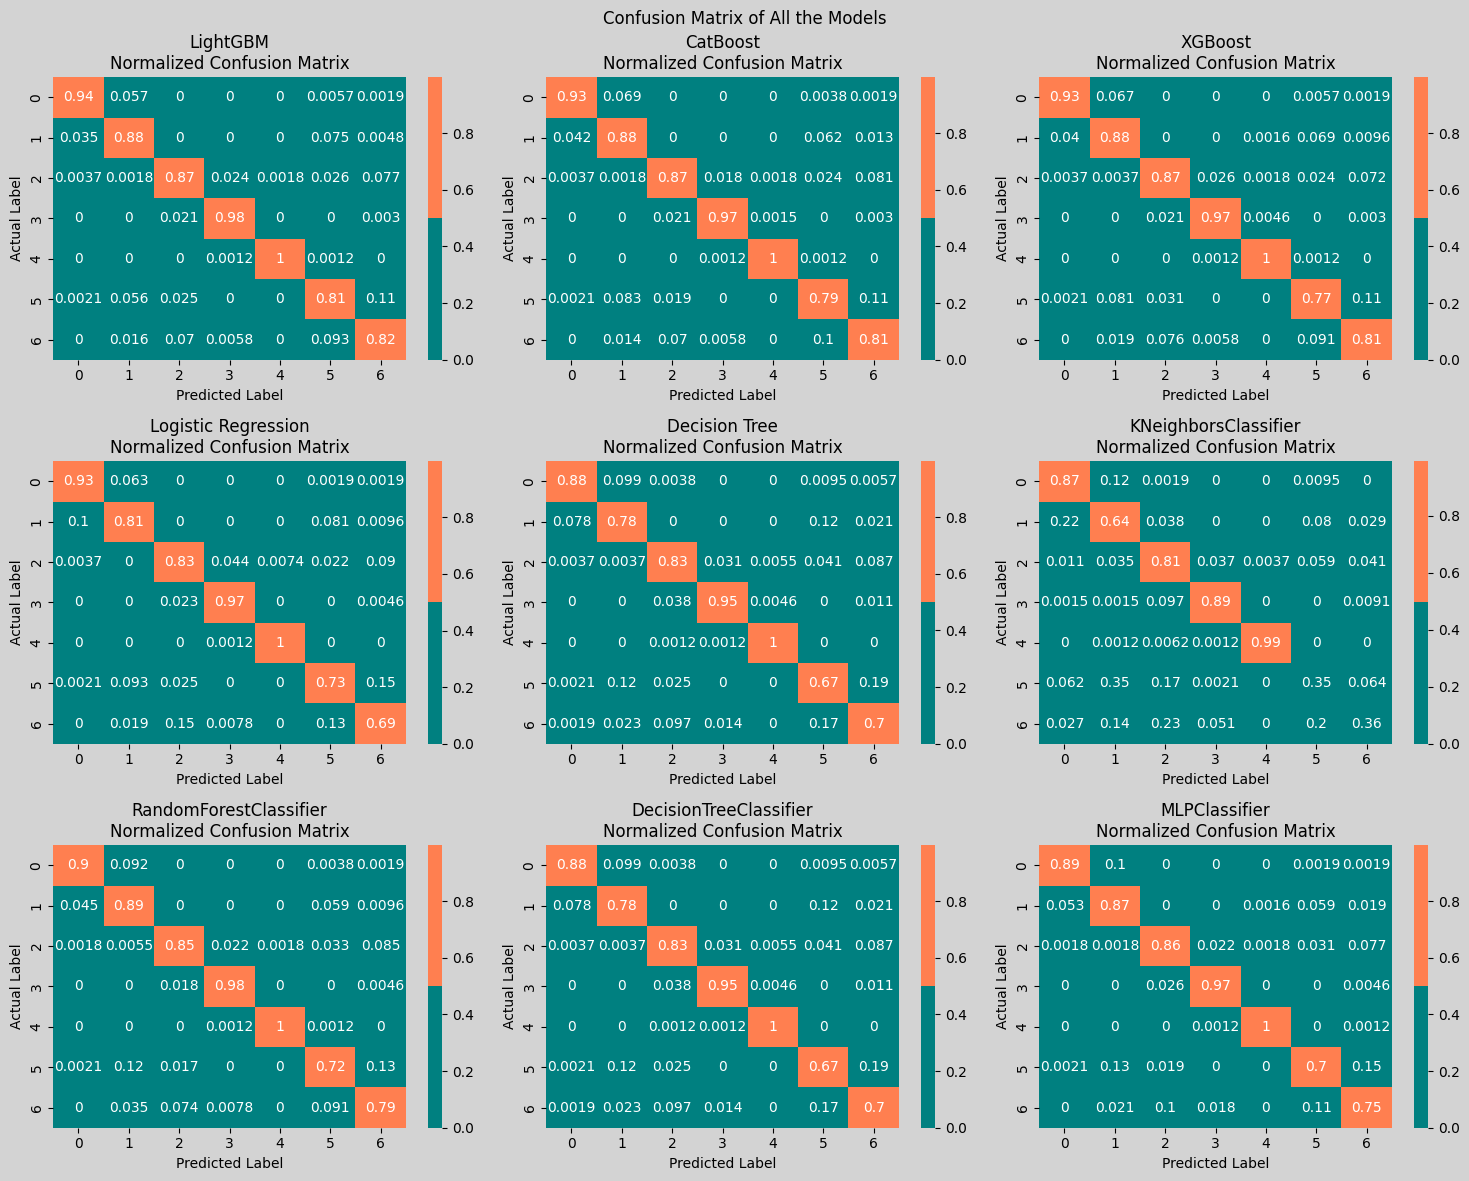

In [28]:
# Train and evaluate models
num_rows = 3
num_columns = ceil(len(classifiers) / num_rows)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 12))

# Train and evaluate models
for name, classifier in tqdm(classifiers.items(), desc='Training models', unit='model'):
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    model.fit(X_train, y_train)

    test_predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, test_predictions)
    conf_matrix = confusion_matrix(y_test, test_predictions, normalize='true')
    classification_rep = classification_report(y_test, test_predictions)

    performance_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix,
        'Classification Report': classification_rep
    })
    
    # Plot the confusion matrix
    idx = list(classifiers.keys()).index(name)
    row_idx = idx // num_columns
    col_idx = idx % num_columns
    
    sns.heatmap(conf_matrix, annot=True, cmap=['teal', 'coral'], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'{name}\nNormalized Confusion Matrix')
    axes[row_idx, col_idx].set_xlabel('Predicted Label')
    axes[row_idx, col_idx].set_ylabel('Actual Label')

plt.suptitle('Confusion Matrix of All the Models')
plt.tight_layout()
plt.show()

In [29]:
# Create a VotingClassifier
voting_classifier = VotingClassifier(estimators=list(classifiers.items()), voting='soft')
voting_classifier

VotingClassifier(estimators=[('LightGBM',
                              LGBMClassifier(class_weight='balanced',
                                             colsample_bytree=0.4097712934687264,
                                             force_col_wise=True,
                                             lambda_l1=0.009667446568254372,
                                             lambda_l2=0.040186414373018,
                                             learning_rate=0.03096221154683276,
                                             max_depth=20,
                                             metric='multi_logloss',
                                             min_child_samples=26,
                                             n_estimators=550, num_class=7,
                                             objective='multiclass',
                                             random_state...
                              DecisionTreeClassifier(random_state=42)),
                             ('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=2)),
                             ('RandomForestClassifier',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=20,
                                                     n_estimators=700,
                                                     random_state=77)),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(random_state=42)),
                             ('MLPClassifier', MLPClassifier(max_iter=1000))],
                 voting='soft')

In [30]:
# Train and evaluate the VotingClassifier
voting_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', voting_classifier)])
voting_model.fit(X_train, y_train)

voting_test_predictions = voting_model.predict(X_test)
voting_test_probabilities = voting_model.predict_proba(X_test)[:, 1]

voting_accuracy = accuracy_score(y_test, voting_test_predictions)
voting_conf_matrix = confusion_matrix(y_test, voting_test_predictions)
voting_classification_rep = classification_report(y_test, voting_test_predictions)

print('Voting Classifier:')
print(f'Voting Classifier - Accuracy on validation set: {voting_accuracy:.2f}')
print(f'Voting Classifier - Confusion Matrix:\n{np.array2string(voting_conf_matrix, precision=2)}')
print(f'Voting Classifier - Classification Report:\n{voting_classification_rep}')

performance_list.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'Confusion Matrix': voting_conf_matrix,
    'Classification Report': voting_classification_rep
})

Voting Classifier:
Voting Classifier - Accuracy on validation set: 0.90
Voting Classifier - Confusion Matrix:
[[489  32   0   0   0   2   1]
 [ 29 543   0   0   0  51   3]
 [  2   1 472  10   1  15  42]
 [  0   0  13 641   1   0   2]
 [  0   0   1   1 802   0   0]
 [  1  41  10   0   0 372  60]
 [  0   9  42   5   0  54 404]]
Voting Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       524
           1       0.87      0.87      0.87       626
           2       0.88      0.87      0.87       543
           3       0.98      0.98      0.98       657
           4       1.00      1.00      1.00       804
           5       0.75      0.77      0.76       484
           6       0.79      0.79      0.79       514

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



# **Evaluating the Model 📝**
---

In [31]:
performance_df = pd.DataFrame(performance_list)
performance_df['Rank'] = performance_df['Accuracy'].rank(ascending=False, method='first').astype(int)
performance_df = performance_df.sort_values(by='Rank')
best_model_performance = performance_df.iloc[0]['Model']

performance_df[['Model', 'Accuracy', 'Rank']].style.background_gradient(cmap='viridis')

,Model,Accuracy,Rank
0,LightGBM,0.907274,1
1,CatBoost,0.902697,2
2,XGBoost,0.900289,3
9,Voting Classifier,0.896676,4
6,RandomForestClassifier,0.888969,5
8,MLPClassifier,0.877649,6
3,Logistic Regression,0.866329,7
4,Decision Tree,0.844171,8
7,DecisionTreeClassifier,0.844171,9
5,KNeighborsClassifier,0.730010,10


In [32]:
best_model = classifiers[best_model_performance]
best_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.4097712934687264,
               force_col_wise=True, lambda_l1=0.009667446568254372,
               lambda_l2=0.040186414373018, learning_rate=0.03096221154683276,
               max_depth=20, metric='multi_logloss', min_child_samples=26,
               n_estimators=550, num_class=7, objective='multiclass',
               random_state=42, subsample=0.9535797422450176, verbose=-1,
               verbosity=-1)

In [33]:
# Train the best model on the entire training dataset
final_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_model)])
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender',
                                                   'family_history_with_overweigh...
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.4097712934687264,
                                force_col_wise=True,
                                lambda_l1=0.009667446568254372,
                                lambda_l2=0.040186414373018,
                                learning_rate=0.03096221154683276, max_depth=20,
                                metric='multi_logloss', min_child_samples=26,
                                n_estimators=550, num_class=7,
                                objective='multiclass', random_state=42,
                                subsample=0.9535797422450176, verbose=-1,
                                verbosity=-1))])

# **Submit the Prediction 🚀**
---

In [34]:
test_prediction = final_model.predict(test_df)

In [35]:
sample_submission["NObeyesdad"] = test_prediction

In [36]:
# See the original class labels
original_labels = labelencoder.classes_
print("Original class labels:", original_labels)

# See the encoded labels
encoded_labels = labelencoder.transform(original_labels)
print("Encoded labels:", encoded_labels)

Original class labels: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
Encoded labels: [0 1 2 3 4 5 6]


In [37]:
# Mapping dictionary for label conversion
label_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Obesity_Type_I',
    3: 'Obesity_Type_II',
    4: 'Obesity_Type_III',
    5: 'Overweight_Level_I',
    6: 'Overweight_Level_II'
}

sample_submission['NObeyesdad'] = sample_submission['NObeyesdad'].map(label_mapping)

In [38]:
sample_submission

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [39]:
sample_submission.to_csv("submission.csv", index=False)

# **References**
---
* [Multi-Class Prediction of Obesity Risk](https://www.kaggle.com/competitions/playground-series-s4e2)
* [PS4E2 Visual EDA LGBM](https://www.kaggle.com/code/ddosad/ps4e2-visual-eda-lgbm#5.-Prediction-on-Test-data)
* [Multi Class Prediction of Obesity Risk](https://www.kaggle.com/code/mohamedtahaouf/multi-class-prediction-of-obesity-risk-9118)